### 🚀 Open this Tutorial in Google Colab  
<a target="_blank" href="https://colab.research.google.com/github/amirhszd/MachineLearning4RemoteSensing/blob/main/hw5/hw5_p1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Mount Google Drive and Load Data

In this step, you’ll mount your Google Drive so that you can access .npy files directly from it. Then, load your training, validation, and test sets using NumPy. Be sure to update the paths to point to your own data files.

Make sure to set to runtime session to use GPU otherwise your training is going to be slow.

Credits To: **Amirhossein Hassanzadeh** (https://github.com/amirhszd/MachineLearning4RemoteSensing/tree/main/hw5) for providing data and resources with this tutorial.

In [ ]:
# Import files and mount google drive
import numpy as np
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
# Step 1: Load your .npy files from your Google Drive

top_path = '/content/drive/MyDrive/... ... ' # include data path


X_train = np.load(top_path + '/landis_chlorophyl_regression_train.npy')
y_train = np.load(top_path + '/landis_chlorophyl_regression_traingt.npy')

X_val = np.load(top_path + '/landis_chlorophyl_regression_val.npy')
y_val = np.load(top_path + '/landis_chlorophyl_regression_valgt.npy')

X_test = np.load(top_path + '/landis_chlorophyl_regression_test.npy')
y_test = np.load(top_path + '/landis_chlorophyl_regression_testgt.npy')

print("Training set shape:", X_train.shape)

Training set shape: (6000, 425)


### Standardize the Data & Create Dataset

Here, you will standardize your dataset using StandardScaler. This ensures that each feature has zero mean and unit variance. Remember to fit the scaler only on the training data, and then transform all splits using that same scaler.

You’ll define a custom PyTorch Dataset to wrap your data and make it compatible with DataLoader. After that, instantiate the datasets and set up data loaders with appropriate batch size and parallel loading settings (num_workers, prefetch_factor).

In [ ]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler

# Step 1: Standard scaling based on training data only
# TODO: Scale your validation and test sets using statistics from the training set only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Step 2: Create custom dataset class
class ChlorophyllDataset(Dataset):
    def __init__(self, X, y):
      # TODO: Convert your numpy arrays to torch tensors with the correct dtype
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Step 3: Instantiate your datasets
train_dataset = ChlorophyllDataset(X_train_scaled, y_train)
val_dataset = ChlorophyllDataset(X_val_scaled, y_val)
test_dataset = ChlorophyllDataset(X_test_scaled, y_test)

# Step 4: Create DataLoaders
# TODO: Set batch_size, num_workers, and prefetch_factor based on your system
from torch.utils.data import DataLoader
batch_size = 32
num_workers = 2
prefetch_factor = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=num_workers, prefetch_factor=prefetch_factor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                       num_workers=num_workers, prefetch_factor=prefetch_factor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, prefetch_factor=prefetch_factor)

print("train dataset size is:", len(train_dataset))
print("val dataset size is:", len(val_dataset))
print("test dataset size is:", len(test_dataset))

train dataset size is: 6000
val dataset size is: 2000
test dataset size is: 2000


### Define Your 1D Convolutional Model
In this step, you’ll define a custom SpectralCNN model using PyTorch’s nn Module. This model consists of a sequence of 1D convolutional layers with increasing filter sizes and stride to reduce the spectral dimension. The final Linear layer maps the learned features to a single output value for regression.

💡 Note: Since your input has shape [batch_size, 425], you’ll need to change the shape accordingly.

In [ ]:
import torch.nn as nn

class SpectralCNN(nn.Module):
    def __init__(self):
        super(SpectralCNN, self).__init__()
        # 8 layer 1D CNN with kernel size 3 and stride of 2
        # stride 2 lowers the dimensionality spectral dimensionality
        # relu is the activation function introducing nonlinearity
        # the bigger the kernel size the more number of parameters to learn

        self.net = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, stride=2), nn.LeakyReLU(negative_slope=0.01),  # [B, 8, 212]
            nn.Conv1d(8, 16, kernel_size=3, stride=2), nn.LeakyReLU(negative_slope=0.01), # [B, 16, 105]
            nn.Conv1d(16, 32, kernel_size=3, stride=2), nn.LeakyReLU(negative_slope=0.01),# [B, 32, 52]
            nn.Conv1d(32, 64, kernel_size=3, stride=2), nn.LeakyReLU(negative_slope=0.01),# [B, 64, 25]
            nn.Conv1d(64, 128, kernel_size=3, stride=2), nn.LeakyReLU(negative_slope=0.01),# [B, 128, 12]
            nn.Conv1d(128, 128, kernel_size=3, stride=2), nn.LeakyReLU(negative_slope=0.01),# [B, 128, 5]
            nn.Conv1d(128, 256, kernel_size=3, stride=2), nn.LeakyReLU(negative_slope=0.01),# [B, 256, 2]
            nn.Conv1d(256, 256, kernel_size=2, stride=1), nn.LeakyReLU(negative_slope=0.01),# [B, 256, 1]
            nn.Flatten(),
            # we are performing regression so output is one value
            nn.Linear(256, 1)
        )

    def forward(self, x):
        # x is of size Nx425, however, we need to define the number of channels for our 1D data
        # in this case there is only 1 channel/feature for our 425 input features
        # in 2D space we have N x C_in x H x W
        # in 1D space we should have N x C_in x Length
        x = x.unsqueeze(1)        # transform [B, 425] -> [B, 1, 425] i.e [B, C, L]
        # Pass through the network
        return self.net(x)

### Define the Model, Optimizer, and Training Configuration

In this section, you will define the loss function for your regression task, instantiate your model, and set up the optimizer of your choice. Make sure to use weight decay to prevent overfitting.

Your training will benefit from learning rate scheduler such as to gradually reduce the learning rate during training. Finally, you’ll move your model to the GPU if available.

💡 Tip: Your learning rate and weight decay are hyperparameters!

In [ ]:
# TODO: Define regression LOSS
criterion = nn.MSELoss()  # Mean Squared Error for regression

# instantiating the model
model = SpectralCNN()

# TODO: define optimizer, suggestion is on Adam with weight decay.
# keep in mind weight decay and learning rate are hyperpareters
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

# TODO: you can define a learning rate scheduler at the time of training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Optional: use GPU if available
# make sure to change your runtime type to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using:", device)

Using: cuda


### Training Loop and Early Stopping

In this section, you will implement the full training loop for your model. For each epoch, you’ll:
	•	Loop through your training data
	•	Send batches to the correct device
	•	Perform forward and backward passes
	•	Update the model using your optimizer

After training on each epoch, you’ll evaluate your model on the validation set without computing gradients. You’ll track the best-performing model based on validation loss and save it using torch.save(). Finally, you’ll step the learning rate scheduler to gradually reduce the learning rate over time.

Make sure to plot loss for training and validation sets, this will help you see into overfitting and underfitting.

🛑 Don’t forget: only update weights during training, and use torch.no_grad() during validation to save memory and speed up evaluation.

In [ ]:
# Initialize variables for early stopping
best_val_loss = float("inf")
best_epoch = -1

# keepong track of validation loss COMPLETE ME
val_loss_history = []

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    train_losses = []

    # TOOD: keep track of any other regression metric you want per

    for X_batch, y_batch in train_loader:
        # TODO: send input features and reference target to device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # zeroing out previous step gradients
        optimizer.zero_grad()

        # send input features and reference target to device
        outputs = model(X_batch)

        # TODO: calculate the loss
        loss = criterion(outputs, y_batch.unsqueeze(1))

        # TODO: calculate the gradients by calling backward on the loss
        loss.backward()

        # TODO: take a step by calling step on the optimizer
        optimizer.step()

        # TODO: keep score of your training loss and any other metric you see fit for
        # your regression task
        train_losses.append(loss.item())

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            # TODO: Same as training but we are not updating weights
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            val_loss = criterion(outputs, y_batch.unsqueeze(1))
            val_losses.append(val_loss.item())

    # TODO: implementing early stopping here.
    # keep track of the validation loss and save the model parameters
    # when the loss is the lowest for the validation set
    val_loss_mean = np.mean(val_losses)
    val_loss_history.append(val_loss_mean)
    if val_loss_mean < best_val_loss:
        best_val_loss = val_loss_mean
        best_epoch = epoch
        torch.save(model.state_dict(), "best_model.pt")

    # TODO: take a step in the scheduler to update the learning rate
    scheduler.step(val_loss_mean)

    # Print summary
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {np.mean(train_losses):.4f} | Val Loss: {val_loss_mean:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

print(f"\nBest model saved from epoch {best_epoch+1} with Val Loss: {best_val_loss:.4f}")

Epoch 1/50 | Train Loss: 386.6994 | Val Loss: 28.0303 | LR: 0.010000
Epoch 2/50 | Train Loss: 25.5598 | Val Loss: 16.8015 | LR: 0.010000
Epoch 3/50 | Train Loss: 21.7500 | Val Loss: 20.8049 | LR: 0.010000
Epoch 4/50 | Train Loss: 20.7558 | Val Loss: 17.3210 | LR: 0.010000
Epoch 5/50 | Train Loss: 18.7433 | Val Loss: 25.5158 | LR: 0.010000
Epoch 6/50 | Train Loss: 22.3814 | Val Loss: 34.8601 | LR: 0.010000
Epoch 7/50 | Train Loss: 17.1906 | Val Loss: 14.5418 | LR: 0.010000
Epoch 8/50 | Train Loss: 20.1567 | Val Loss: 21.2058 | LR: 0.010000
Epoch 9/50 | Train Loss: 19.4686 | Val Loss: 12.6865 | LR: 0.010000
Epoch 10/50 | Train Loss: 23.9989 | Val Loss: 22.9926 | LR: 0.010000
Epoch 11/50 | Train Loss: 20.2674 | Val Loss: 16.8817 | LR: 0.010000
Epoch 12/50 | Train Loss: 17.7214 | Val Loss: 48.2208 | LR: 0.010000
Epoch 13/50 | Train Loss: 18.1098 | Val Loss: 15.0702 | LR: 0.010000
Epoch 14/50 | Train Loss: 16.9314 | Val Loss: 19.4282 | LR: 0.010000
Epoch 15/50 | Train Loss: 16.1524 | Val Lo

### Get predictions and plot your results
Get predictions on your test set and plot your regression results for your training and test set.

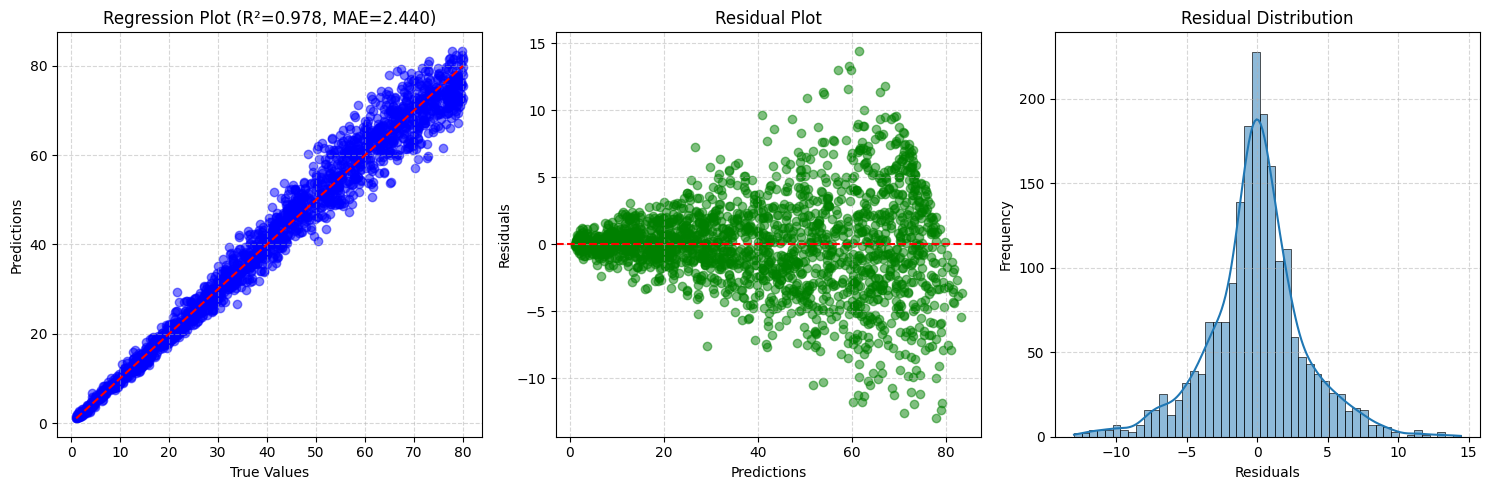

Performance Metrics:
R² Score: 0.9780
MAE: 2.4399
RMSE: 3.4316
Sample Size: 2000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score

# TODO: we are to check the model's performance on the validation set
# load the "best_model.pt" and pass your test data to it and get predictions
# make sure the model is in eval mode, send the data to device
# note: make sure you handled "shuffle" properly in your validation/testing set
# loading the best model

model.load_state_dict(torch.load("best_model.pt", weights_only=True))
model.eval()
model.to(device)
predictions = []
actual = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds = model(X_batch)
        predictions.extend(preds.squeeze().cpu().numpy())
        actual.extend(y_batch.cpu().numpy())

#TODO: plot regression plot and residual plots for your regression task,
# report R2, and MAE along with any other metrics you want
# analyze your results and report on your findings.

# Convert to numpy arrays
predictions = np.array(predictions)
actual = np.array(actual)

# Calculate metrics
mae = mean_absolute_error(actual, predictions)
r2 = r2_score(actual, predictions)
rmse = np.sqrt(np.mean((actual - predictions)**2))

# Create figure
plt.figure(figsize=(15, 5))

# Regression plot
plt.subplot(1, 3, 1)
plt.scatter(actual, predictions, color='blue', alpha=0.5)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True, linestyle='--', alpha = 0.5)
plt.title(f'Regression Plot (R²={r2:.3f}, MAE={mae:.3f})')

# Residual plot
plt.subplot(1, 3, 2)
residuals = actual - predictions
plt.scatter(predictions, residuals, color='green', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.grid(True, linestyle='--', alpha = 0.5)
plt.title('Residual Plot')

# Residual distribution
plt.subplot(1, 3, 3)
sns.histplot(residuals, bins=50, alpha=0.5, kde=True)
plt.ylabel('Frequency')
plt.xlabel('Residuals')
plt.grid(True, linestyle='--', alpha = 0.5)
plt.title('Residual Distribution')


plt.tight_layout()
plt.show()

print(f"Performance Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Sample Size: {len(actual)}")

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

---
---

### **Comments**  

Using the **1D-CNN** model we were able to achive approx. R-squared of 98%, MAE of 2.40, RMSE of 3.41 on 2000 testing samples. The trendline is is almost linear and perfect and the residuals are normally distributed. However, there exist clearly visible *heteroscedasticity* in the predictions. This can seen in *residual plot* where the residual magnitude is increasing with the predictions which means prediction uncertainty rises for higher predicted values. This might be due to some non-linearity in the relation between predictor variable (spectra) and target variable (chlorophyll) which the model couldn't learn. Such non-linearity could be due to saturation of spectral response after certain higher chlorophyll content concentration and hence leading to underestimation at higher values. This kind of signal saturation behavior is one of the classic problem in chlorophyll remote sensing where reflectance in chlorophyll-sensitive bands (red, blue and NIR) becomes insensitive to further increases in chlorophyll at high concentrations. Overall the model is good enough considering the simplicity of **1D-CNN** model.

---
---

</div>

### Hyperparamter Tuning
This part is all you. You have a base model that is performing somewhat accurately for you. Grab a package and perform hyperparameter tuning on your hyperparameters. Read Below!!!

In [ ]:
# TODO: now that we have a base model that things are working, we perform hyperparameter tuning on validation data

# change the learning rate value---> tested for higher (0.01) and lower (0.0001) learning rate: kept higher
# number of layers --> didnt test
# filter size (the bigger the filter size the more computationally expensive)--> didnt test
# instead of ReLU use leaky Relu or Tanh ---> used leaky relu: some improvement
# learning weight decay --> increased decay to (1e-04): some improvement
# using max/average pooling instead of stride 2 --> didnt improve result
# incorporating padding--> didnt improve much
# you can log the lowest loss (highest accuracy) on your validation set and report that --> done
